<a href="https://colab.research.google.com/github/mustafacakar/stock-price-prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [56]:
#imports
%matplotlib inline
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #r^2 hesaplaması için
import math                  #Matematiksel işlemler için
import matplotlib            #Veri görselleştirilmesi için
import multiprocessing
import numpy as np
import pandas as pd          #Veri işlemek, anlamlandırmak için
import seaborn as sns        #İstatiksel grafikler için
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date, datetime, timedelta
from fbprophet import Prophet #Prophet Algoritması için
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error    
from tqdm import tqdm_notebook        ## ProgressBars


import plotly.graph_objects as go

import pandas as pd
from datetime import datetime


# Constant Parameters

In [57]:
# Constant Parameters
APPLE_DATA_PATH = "/content/data/AAPL.csv"           ## APPLE Historical financial stock market values
#holidays_path = "/content/holidays.csv"             # Amerika Borsa Tatil günlerinin csv dosyası // csv file containing holidays in the US
H = 21                                               # Tahminleme Uzunluğu // Forecast Horizon
TRAIN_SIZE = 503                                     # 2 yıl eğitim için seçilmiştir. Yaklaşık olarak bir yılda 252 işlem günü vardır. Use 2 years of data as train 

# Loss Functions

In [58]:
# Loss Functions




def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_r2 (a, b):
    """
    Comp R^2. a and b can be lists.
    Returns a scalar.
    """
    return r2_score(a, b)


# Read Data

In [59]:
# Read APPLE Stock Price CSV
df = pd.read_csv(APPLE_DATA_PATH, sep = ",")

# Sort Ascending
df.sort_values(by='Date', inplace=True, ascending=True)


# Tarih kolonunun formatının datetime'a dönüştürülmesi
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Data Length
print("Data Length ( Veri sayısı) : " + str(len(df)))

df.head(10)

Data Length ( Veri sayısı) : 1259


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-21,35.527500,35.700001,34.932499,34.959999,33.007835,158119600
1,2017-03-22,34.962502,35.400002,34.939999,35.355000,33.380775,103440800
2,2017-03-23,35.314999,35.395000,35.152500,35.230000,33.262756,81385200
3,2017-03-24,35.375000,35.435001,35.087502,35.160000,33.196659,89582400
4,2017-03-27,34.847500,35.305000,34.654999,35.220001,33.253304,94300400
5,2017-03-28,35.227501,36.009998,35.154999,35.950001,33.942543,133499200
6,2017-03-29,35.919998,36.122501,35.797501,36.029999,34.018082,116760000
7,2017-03-30,36.047501,36.125000,35.875000,35.982498,33.973232,84829200
8,2017-03-31,35.930000,36.067501,35.752499,35.915001,33.909512,78646800
9,2017-04-03,35.927502,36.029999,35.762501,35.924999,33.918941,79942800


# Get Data Info

In [60]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.7 KB


In [61]:
# statistical data of DF 
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,80.347117,81.246017,79.479112,80.402458,79.203551,1.203777e+08
std,43.679665,44.219203,43.124999,43.693886,44.172939,5.543855e+07
min,34.847500,35.305000,34.654999,34.959999,33.007835,4.100000e+07
25%,43.758749,44.015001,43.489999,43.754999,42.225983,8.358420e+07
50%,56.365002,56.872501,55.642502,56.147499,54.798798,1.054740e+08
75%,122.599998,124.090000,120.810001,122.475003,121.659042,1.404340e+08
max,182.630005,182.940002,179.119995,182.009995,181.778397,4.265100e+08


In [62]:
# Null Value Check in DF 
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

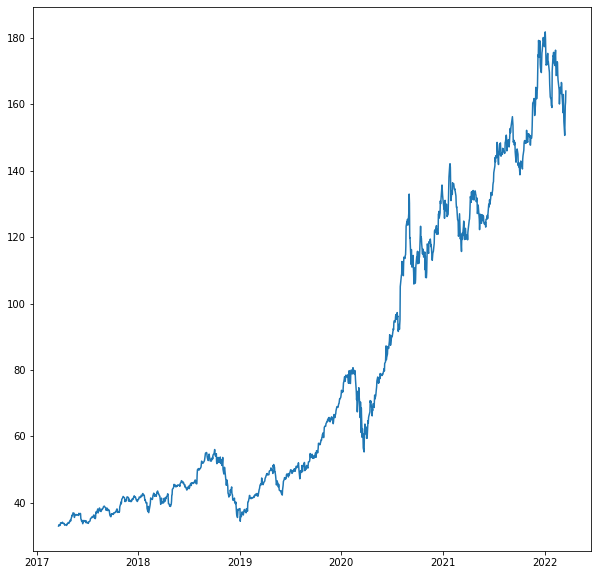

In [63]:
# Graphics of APPLE Stock Price
plt.figure(figsize=(10,10))
plt.plot(df['Date'],df['Adj Close'])

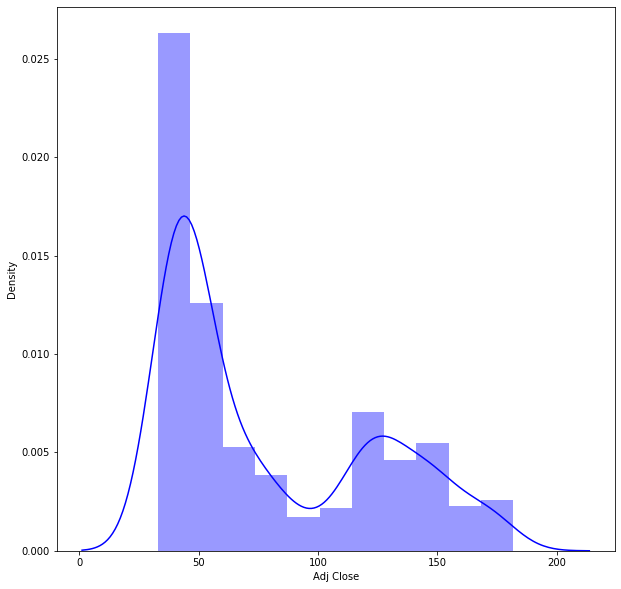

In [64]:
#Ayarlanmış Kapanış Fiyatı (Adj Close) dağılım grafiği
plt.figure(figsize=(10,10))
sns.distplot(df['Adj Close'], color='b')

In [65]:
#2017-2022 Candlestick Graphic of APPLE Stock Prices

fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Adj Close'])])

fig.show()


# Date Range of APPLE Stock Prices
df['Date'].min(), df['Date'].max() 

(Timestamp('2017-03-21 00:00:00'), Timestamp('2022-03-18 00:00:00'))

# Preparation for Prophet Algorithm

**Rename Columns for Prophet**


In [66]:
df_prophet = df[['Date', 'Adj Close']].rename(columns={'Date':'ds', 'Adj Close':'y'})
df_prophet.head()

,ds,y
0,2017-03-21,33.007835
1,2017-03-22,33.380775
2,2017-03-23,33.262756
3,2017-03-24,33.196659
4,2017-03-27,33.253304


**Train from "start_date" and Calculate Prediction Time**

In [67]:
    i = TRAIN_SIZE 
    start_date = df_prophet.iloc[i]['ds']
    print(" Tarih : "+str(start_date)+"'inden itibaren (%d. gün), %d günlük tahmin" % (
         i, H))

 Tarih : 2019-03-21 00:00:00'inden itibaren (503. gün), 21 günlük tahmin


In [68]:
m = Prophet()
m.fit(df_prophet) 
df_cv = cross_validation(m, initial='1000 days',horizon='21 days', period='5 days', parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_r = get_r2(df_cv['y'],df_cv['yhat'])
rmses_parametresiz=df_p['rmse'].values[0]
mses_parametresiz=df_p['mse'].values[0]
maes_parametresiz=df_p['mae'].values[0]
mapes_parametresiz=df_p['mape'].values[0]
r2_parametresiz=df_r
print(df_cv)
# Hata metriklerinin hesaplanması

print('Rmses:{0} ' .format(rmses_parametresiz))
print('MSES:{0}  '.format(mses_parametresiz))
print('Maes:{0} ' .format(maes_parametresiz))
print('R2:{0} '  .format(r2_parametresiz))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 161 forecasts with cutoffs between 2019-12-18 00:00:00 and 2022-02-25 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f444ec84f50>


             ds        yhat  yhat_lower  yhat_upper           y     cutoff
0    2019-12-19   67.321646   65.647510   68.927137   68.892593 2019-12-18
1    2019-12-20   67.329262   65.636177   68.972788   68.749893 2019-12-18
2    2019-12-23   67.307859   65.555527   69.159478   69.871773 2019-12-18
3    2019-12-24   67.401907   65.654361   69.062123   69.938210 2019-12-18
4    2019-12-26   67.443367   65.591666   69.174919   71.325798 2019-12-18
...         ...         ...         ...         ...         ...        ...
2325 2022-03-14  166.882436  161.471743  172.373692  150.619995 2022-02-25
2326 2022-03-15  167.000893  161.695346  172.998815  155.089996 2022-02-25
2327 2022-03-16  166.907725  161.088170  172.412481  159.589996 2022-02-25
2328 2022-03-17  166.709366  160.843990  172.537629  160.619995 2022-02-25
2329 2022-03-18  166.546466  161.337708  172.193324  163.979996 2022-02-25

[2330 rows x 6 columns]
Rmses:8.891389650238438 
MSES:79.05680991236721  
Maes:7.063794637058906 
R

# First Prediction

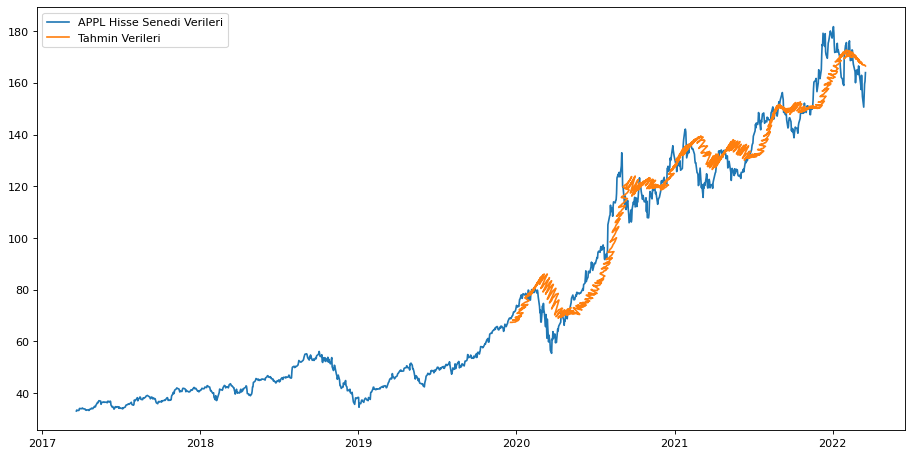

In [69]:

plt.figure(figsize=[14,7],dpi=80)
plt.plot(df['Date'],df['Adj Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend(['APPL Hisse Senedi Verileri','Tahmin Verileri'])
plt.savefig(fname="Tahminleme.png")

# Fitting Model


In [70]:
# Prophet Modeli Fitleme
m = Prophet()
m.fit(df_prophet[i-TRAIN_SIZE:i])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Remove Weekend Days from Prediction

In [71]:
future = m.make_future_dataframe(periods=H)

In [72]:
# Remove weekends from future prediction / Gelecekteki verilerden hafta sonunu çıkarılması

future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]
print(future.head(10))
future.to_csv('Future.csv')
# Prediction / Tahminleme Methodu ile tahminlemenin yapılması(Alt sınır ve üst sınır tahminlerinin yapılması) 
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.to_csv('Forecast.csv')


          ds  day
0 2017-03-21    1
1 2017-03-22    2
2 2017-03-23    3
3 2017-03-24    4
4 2017-03-27    0
5 2017-03-28    1
6 2017-03-29    2
7 2017-03-30    3
8 2017-03-31    4
9 2017-04-03    0


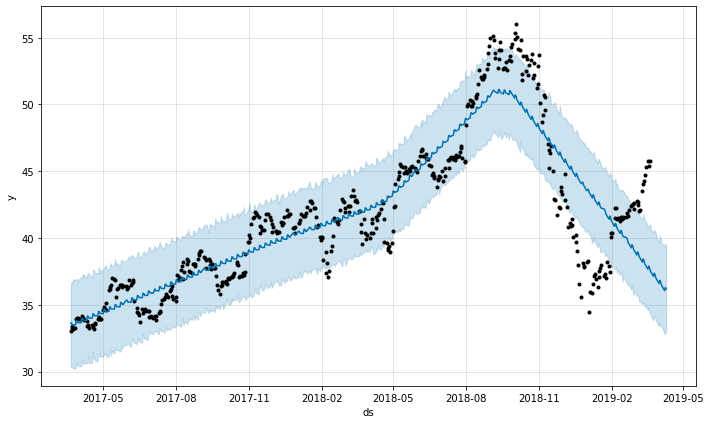

In [73]:
m.plot(forecast);

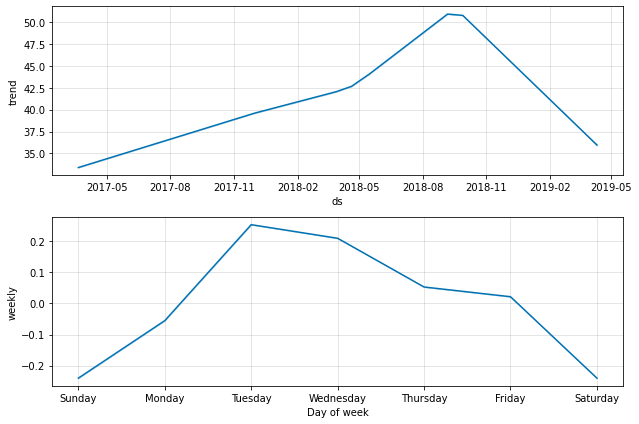

In [74]:
# Bileşenleri Çizme
m.plot_components(forecast);

# Prophet Calculate Error Mertics 

In [75]:
preds_list = forecast['yhat'][TRAIN_SIZE:len(future)]
print(len(preds_list))

print(len(df_prophet[TRAIN_SIZE:len(future)]['y']))

print(len(future))
#deger = get_rmse(df_prophet[TRAIN_SIZE:len(future)]['y'], preds_list)


print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin RMSE değeri %f" % ( df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_rmse(df_prophet[TRAIN_SIZE:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama MAPE değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_mape(df_prophet[TRAIN_SIZE:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama MAE değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_mae(df_prophet[TRAIN_SIZE:len(future)]['y'], preds_list)))
print("%s tarihinden itibaren (%d. gün) , %d günlük tahminin ortalama R2 değeri %f" % (df['Date'][i].strftime("%m/%d/%Y"),i,len(future)-i, get_r2( df_prophet[TRAIN_SIZE:len(future)]['y'], preds_list )))

15
15
518
03/21/2019 tarihinden itibaren (503. gün) , 15 günlük tahminin RMSE değeri 10.393072
03/21/2019 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama MAPE değeri 21.789085
03/21/2019 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama MAE değeri 10.289878
03/21/2019 tarihinden itibaren (503. gün) , 15 günlük tahminin ortalama R2 değeri -92.301177


(737849.0, 737895.0)

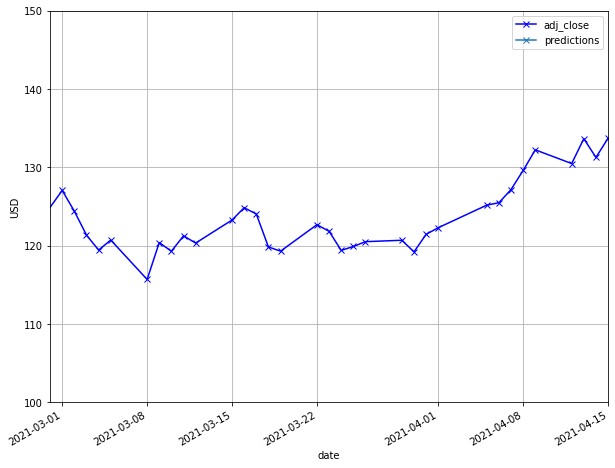

In [76]:
# Tahminlerin çizilmesi
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='Date', y='Adj Close', style='bx-', grid=True)

ax.plot(df['Date'][i:len(future)], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([100, 150])
ax.set_xlim([date(2021, 2, 28), date(2021, 4, 15)])

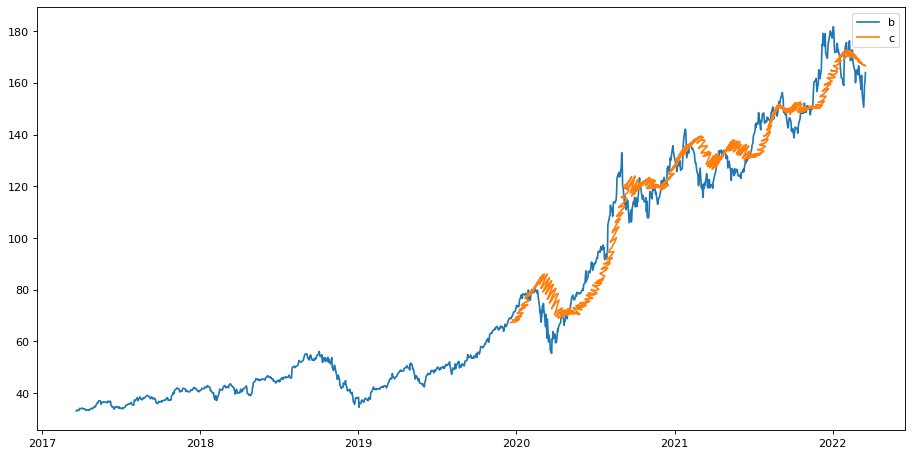

In [77]:
plt.figure(figsize=[14,7],dpi=80)
plt.plot(df['Date'],df['Adj Close'])
plt.plot(df_cv['ds'],df_cv['yhat'])
plt.legend(['b','c'])
plt.savefig(fname="Tahminleme.png")


# LSTM Algorithm

# LSTM Imports


In [158]:
# import for lstm 
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from keras import layers
from keras import models

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [159]:
#training_dataset = pd.read_csv('/content/data/apple_lstm.csv')
training_dataset = pd.read_csv(APPLE_DATA_PATH, sep = ",")
training_dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-21,35.527500,35.700001,34.932499,34.959999,33.007835,158119600
1,2017-03-22,34.962502,35.400002,34.939999,35.355000,33.380775,103440800
2,2017-03-23,35.314999,35.395000,35.152500,35.230000,33.262756,81385200
3,2017-03-24,35.375000,35.435001,35.087502,35.160000,33.196659,89582400
4,2017-03-27,34.847500,35.305000,34.654999,35.220001,33.253304,94300400
...,...,...,...,...,...,...,...
1254,2022-03-14,151.449997,154.119995,150.100006,150.619995,150.619995,108732100
1255,2022-03-15,150.899994,155.570007,150.380005,155.089996,155.089996,92964300
1256,2022-03-16,157.050003,160.000000,154.460007,159.589996,159.589996,102300200
1257,2022-03-17,158.610001,161.000000,157.630005,160.619995,160.619995,75615400


In [160]:
#Checking for null values and returning respective totals
print (training_dataset.isnull().sum())
total_null = training_dataset.isnull().sum().sum()
print ("The total number of null values is: " + str(total_null))

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
The total number of null values is: 0


In [161]:
#Drop every column except the open, high and low columns

training_dataset.drop(['Date', 'Close', 'Volume'], axis = 1, inplace = True)


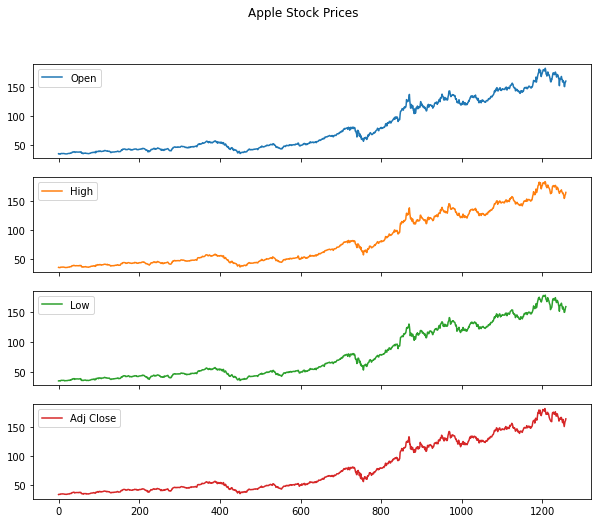

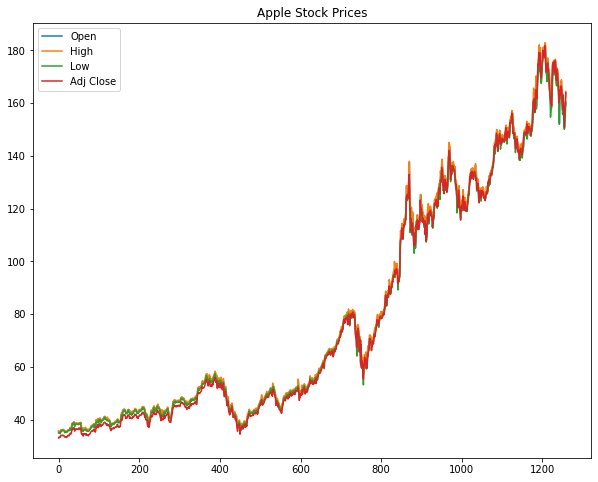

In [162]:
#Visualize the stock price data
training_dataset.plot.line(subplots = True, title='Apple Stock Prices')
training_dataset.plot(title='Apple Stock Prices')

In [163]:
#Drop the high and low columns 
training_dataset.drop(['High','Open','Low'], axis = 1, inplace = True)
#Drop the bottom 2 columns
training_dataset.drop(training_dataset.tail(2).index,inplace=True)
print(training_dataset)
print(training_dataset.shape)

       Adj Close
0      33.007835
1      33.380775
2      33.262756
3      33.196659
4      33.253304
...          ...
1252  158.520004
1253  154.729996
1254  150.619995
1255  155.089996
1256  159.589996

[1257 rows x 1 columns]
(1257, 1)


In [164]:
#Convert the data into numpy array
train_data = training_dataset.to_numpy()
train_data

array([[ 33.007835],
       [ 33.380775],
       [ 33.262756],
       ...,
       [150.619995],
       [155.089996],
       [159.589996]])

In [165]:
#From the dataset, separate into training and testing data with 80/20 percentile 
dataset_train = np.array(train_data[:int(train_data.shape[0]*0.8)])
dataset_test = np.array(train_data[int(train_data.shape[0]*0.8):])
#Find number of columns for each dataset
print(dataset_train.shape)
print(dataset_test.shape)

(1005, 1)
(252, 1)


In [166]:
#Scale the data to range[0,1]
#MinMaxScalar subtracts the minimum value in each feature and divides by the range(difference between original min and max)
scalar = MinMaxScaler(feature_range = (0,1))
train_data = scalar.fit_transform(dataset_train)
train_data.shape

(1005, 1)

In [167]:
#Declare the x_train and y_train 
x_train = train_data[0:1004]
y_train = train_data[1:1005]

x_train = np.reshape(x_train, (1004,1,1))
x_train.shape

(1004, 1, 1)

In [168]:
#Instantiate the Sequential model class 
model = Sequential()
#Set the number of neurons/nodes with the units parameter
#Return_sequences=True reflects adding more layers
model.add(LSTM(units=96, return_sequences=True, input_shape=(None, 1)))
#Add dropout to reduce over-fitting
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
#Add dense layer to reduce spacial parameters of the vector
model.add(Dense(units=1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, None, 96)          37632     
                                                                 
 dropout_16 (Dropout)        (None, None, 96)          0         
                                                                 
 lstm_17 (LSTM)              (None, None, 96)          74112     
                                                                 
 dropout_17 (Dropout)        (None, None, 96)          0         
                                                                 
 lstm_18 (LSTM)              (None, None, 96)          74112     
                                                                 
 dropout_18 (Dropout)        (None, None, 96)          0         
                                                                 
 lstm_19 (LSTM)              (None, 96)               

In [169]:
#Compile the model
model.compile(optimizer = 'adam', loss = "mean_squared_error")

In [170]:
#Train the model for 100 epochs with 32 training examples used in each iteration
model.fit(x_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
32/32 [==============================] - 8s 10ms/step - loss: 0.0990
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0360
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 7/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 8/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0019
Epoch 9/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 10/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 11/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 12/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 13/100
32/32 [===========

In [171]:
#Display the testing dataset
print(dataset_test)
print(dataset_test.shape)

[[119.817856]
 [119.281052]
 [122.660973]
 [121.815994]
 [119.380455]
 [119.877495]
 [120.493835]
 [120.672775]
 [119.191582]
 [121.428291]
 [122.27327 ]
 [125.156136]
 [125.464302]
 [127.144318]
 [129.589783]
 [132.214188]
 [130.464584]
 [133.635727]
 [131.249924]
 [133.705307]
 [133.36734 ]
 [134.043304]
 [132.323547]
 [132.711212]
 [131.160446]
 [133.526382]
 [133.924026]
 [133.595947]
 [132.790756]
 [132.691345]
 [130.683289]
 [131.756897]
 [127.094604]
 [127.34314 ]
 [128.97345 ]
 [129.660553]
 [126.314713]
 [125.378677]
 [122.251923]
 [124.44265 ]
 [126.912178]
 [125.737152]
 [124.323151]
 [124.163826]
 [126.772766]
 [124.900703]
 [126.563652]
 [126.364502]
 [126.314713]
 [124.751335]
 [124.084167]
 [123.755562]
 [124.532265]
 [123.018684]
 [125.358765]
 [125.368721]
 [126.205177]
 [126.593529]
 [125.577835]
 [126.812599]
 [129.929382]
 [129.092926]
 [129.6008  ]
 [131.233856]
 [129.909485]
 [131.741699]
 [133.414627]
 [133.135803]
 [132.847031]
 [132.548294]
 [134.211243]
 [135.

In [172]:
#Reshape the training data and scale
inputs = np.reshape(scalar.transform(dataset_test), (252,1,1))
#Reverse the scaled predictions to their original values  
stock_prediction = scalar.inverse_transform(model.predict(inputs))
stock_prediction

array([[119.17836 ],
       [118.76523 ],
       [121.28713 ],
       [120.67464 ],
       [118.84209 ],
       [119.22398 ],
       [119.69196 ],
       [119.82666 ],
       [118.69594 ],
       [120.38953 ],
       [121.00763 ],
       [123.022514],
       [123.229034],
       [124.32377 ],
       [125.8205  ],
       [127.29388 ],
       [126.32719 ],
       [128.03253 ],
       [126.76887 ],
       [128.06757 ],
       [127.89631 ],
       [128.23643 ],
       [127.3522  ],
       [127.55696 ],
       [126.719185],
       [127.97721 ],
       [128.17712 ],
       [128.01244 ],
       [127.59857 ],
       [127.54654 ],
       [126.451454],
       [127.047295],
       [124.29214 ],
       [124.4498  ],
       [125.45433 ],
       [125.86205 ],
       [123.78981 ],
       [123.17182 ],
       [120.99217 ],
       [122.53768 ],
       [124.17568 ],
       [123.41042 ],
       [122.45558 ],
       [122.34572 ],
       [124.08624 ],
       [122.85001 ],
       [123.95141 ],
       [123.8

In [173]:
stock_prediction = np.squeeze(stock_prediction)
stock_prediction

array([119.17836 , 118.76523 , 121.28713 , 120.67464 , 118.84209 ,
       119.22398 , 119.69196 , 119.82666 , 118.69594 , 120.38953 ,
       121.00763 , 123.022514, 123.229034, 124.32377 , 125.8205  ,
       127.29388 , 126.32719 , 128.03253 , 126.76887 , 128.06757 ,
       127.89631 , 128.23643 , 127.3522  , 127.55696 , 126.719185,
       127.97721 , 128.17712 , 128.01244 , 127.59857 , 127.54654 ,
       126.451454, 127.047295, 124.29214 , 124.4498  , 125.45433 ,
       125.86205 , 123.78981 , 123.17182 , 120.99217 , 122.53768 ,
       124.17568 , 123.41042 , 122.45558 , 122.34572 , 124.08624 ,
       122.85001 , 123.95141 , 123.82222 , 123.78981 , 122.74857 ,
       122.2906  , 122.0621  , 122.5991  , 121.54271 , 123.15851 ,
       123.16516 , 123.71833 , 123.97072 , 123.30468 , 124.111824,
       126.01902 , 125.5259  , 125.82698 , 126.75996 , 126.00745 ,
       127.03902 , 127.920425, 127.7776  , 127.62794 , 127.47129 ,
       128.31941 , 129.05379 , 129.3375  , 129.47395 , 130.569

In [174]:
stock_prediction = stock_prediction.reshape(-1,1)
stock_prediction

array([[119.17836 ],
       [118.76523 ],
       [121.28713 ],
       [120.67464 ],
       [118.84209 ],
       [119.22398 ],
       [119.69196 ],
       [119.82666 ],
       [118.69594 ],
       [120.38953 ],
       [121.00763 ],
       [123.022514],
       [123.229034],
       [124.32377 ],
       [125.8205  ],
       [127.29388 ],
       [126.32719 ],
       [128.03253 ],
       [126.76887 ],
       [128.06757 ],
       [127.89631 ],
       [128.23643 ],
       [127.3522  ],
       [127.55696 ],
       [126.719185],
       [127.97721 ],
       [128.17712 ],
       [128.01244 ],
       [127.59857 ],
       [127.54654 ],
       [126.451454],
       [127.047295],
       [124.29214 ],
       [124.4498  ],
       [125.45433 ],
       [125.86205 ],
       [123.78981 ],
       [123.17182 ],
       [120.99217 ],
       [122.53768 ],
       [124.17568 ],
       [123.41042 ],
       [122.45558 ],
       [122.34572 ],
       [124.08624 ],
       [122.85001 ],
       [123.95141 ],
       [123.8

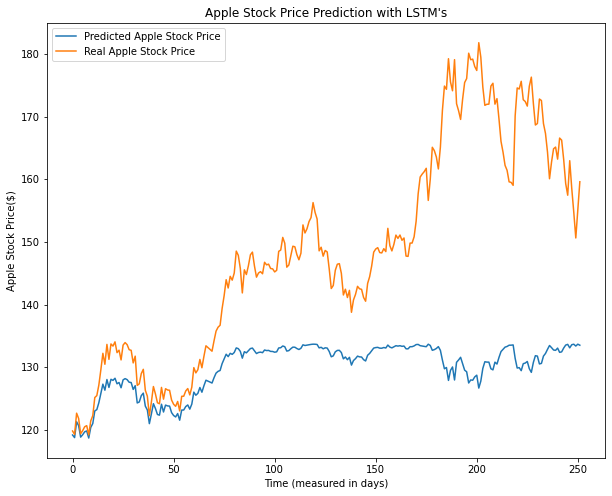

In [175]:
#Graph the real stock prices against the model's prediction
plt.plot(stock_prediction, label = 'Predicted Apple Stock Price', linewidth = 1.5)
plt.plot(dataset_test, label = 'Real Apple Stock Price', linewidth = 1.5)
plt.title("Apple Stock Price Prediction with LSTM's")
plt.xlabel('Time (measured in days)')
plt.ylabel('Apple Stock Price($)')
plt.legend()
plt.show()

In [176]:
#Calculate the standard deviation of the residuals
rmse_value = math.sqrt(mean_squared_error(dataset_test, stock_prediction))
rmse_value = round(rmse_value, 3)
print(rmse_value)

23.452


In [177]:
#Extrapolate the minimum and maximum real stock price values
maxValTest = round(float(max(dataset_test)), 2)
minValTest = round(float(min(dataset_test)), 2)
print ("The real maximum stock price is: " + str(maxValTest) +" dollars")
print ("The real minimum stock price is: " + str(minValTest) + " dollars")

The real maximum stock price is: 181.78 dollars
The real minimum stock price is: 119.19 dollars


In [178]:
#Extrapolate the minimum and maximum real stock price values
maxValPredict = round(float(max(stock_prediction)), 2)
minValPredict = round(float(min(stock_prediction)), 2)
print ("The predicted maximum stock price is: " + str(maxValPredict) +" dollars")
print ("The predicted minimum stock price is: " + str(minValPredict) +" dollars")

The predicted maximum stock price is: 133.67 dollars
The predicted minimum stock price is: 118.7 dollars


In [179]:
#Calculate error and model accuracy with MAPE
total = 0
for i, j in zip(dataset_test, stock_prediction):
    value = abs(i - j) / abs(i)
    total += value
error = float(total*100/(len(dataset_test))) #calculate mape
mape = round(error, 1) #round to 3 significant figures
accuracy = 100 - mape #Calculate accuracy
print ("The LSTM's accuracy in predicting the stock price is: " + str(accuracy) + "%")

The LSTM's accuracy in predicting the stock price is: 88.5%


# ARIMA

# ARIMA Imports

In [205]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [206]:
df = pd.read_csv(APPLE_DATA_PATH, sep = ",")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-21,35.527500,35.700001,34.932499,34.959999,33.007835,158119600
1,2017-03-22,34.962502,35.400002,34.939999,35.355000,33.380775,103440800
2,2017-03-23,35.314999,35.395000,35.152500,35.230000,33.262756,81385200
3,2017-03-24,35.375000,35.435001,35.087502,35.160000,33.196659,89582400
4,2017-03-27,34.847500,35.305000,34.654999,35.220001,33.253304,94300400


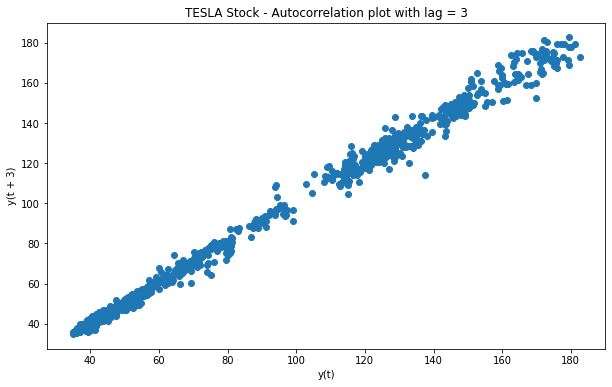

In [207]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('APPLE Stock - Autocorrelation plot with lag = 3')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


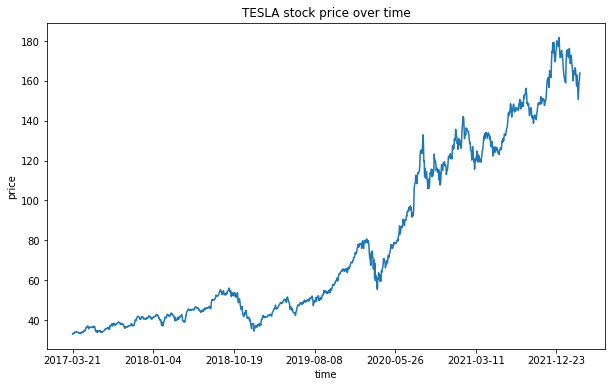

In [208]:
plt.plot(df["Date"], df["Adj Close"])
plt.xticks(np.arange(0,1259, 200), df['Date'][0:1259:200])
plt.title("APPLE stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [214]:
import statsmodels.api as sm
import statsmodels.api as smapi


train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Adj Close'].values
test_data = test_data['Adj Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = sm.tsa.arima.ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 6.117579858289922


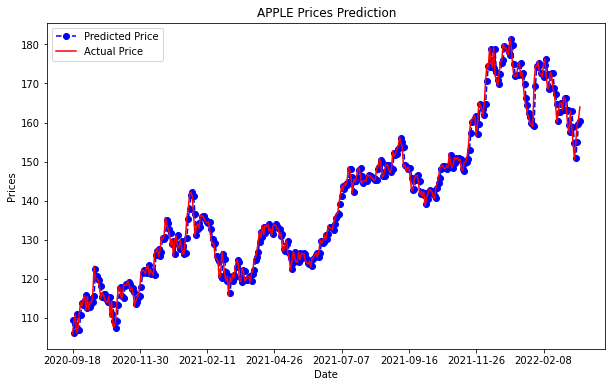

In [216]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('APPLE Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()